# DSN 発表用スクリプト
3/15

In [1]:
import os
import sys

In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import pymc3 as pm

In [3]:
import numpy as np
np.random.seed(0)

In [4]:
path_fig = "../figures/"

## バンディット問題を解くアルゴリズム

### 環境の設定

In [5]:
n_arms = 4

In [6]:
class Env(object):
    thetas = [0.1, 0.1, 0.2, 0.3]
    
    def react(arm):
        return 1 if np.random.random() < Env.thetas[arm] else 0
    
    def opt():
        return np.argmax(Env.thetas)

### $\epsilon$ greedy

In [7]:
class EpsilonGreedyAgent(object):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm]-1) * self.values[arm] + reward
        ) / self.counts[arm]

In [8]:
def sim(Agent, N=1000, T=1000, **kwargs):
    selected_arm = [[0 for _ in range(T)] for _ in range(N)]
    earned_rewards = [[0 for _ in range(T)] for _ in range(N)]
    
    for n in tqdm(range(N)):
        agent = Agent(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = Env.react(arm)
            agent.sample(arm, reward)
            selected_arm[n][t] = arm
            earned_rewards[n][t] = reward
    return np.array(selected_arm), np.array(earned_rewards)

In [9]:
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.24it/s]


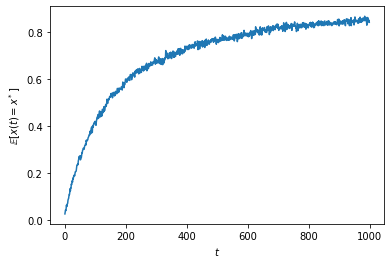

In [10]:
plt.tight_layout()
plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.savefig(path_fig + "result_epsilon_greedy.png", bbox_inches="tight")
plt.show()

### Annealing $\epsilon$ greedy

In [11]:
class AnnealingEpsilonGreedyAgent(object):
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        self.epsilon *= 0.99
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm]-1) * self.values[arm] + reward
        ) / self.counts[arm]

In [12]:
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedyAgent)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.32it/s]


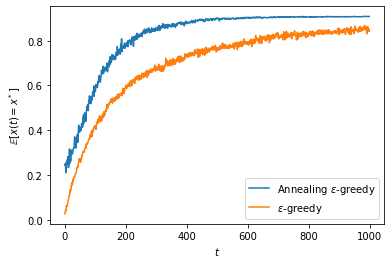

In [13]:
plt.tight_layout()
plt.plot(np.mean(arms_aeg == Env.opt(), axis=0), label=r'Annealing $\epsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0), label=r'$\epsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.savefig(path_fig + "result_annealing_epsilon_greedy.png", bbox_inches="tight")
plt.show()

### Thompson sampling

In [14]:
class BernoulliTSAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.wins = [0 for _ in range(n_arms)]
        
    def get_arm(self):
        beta = lambda N, a: np.random.beta(a+1, N-a+1)
        result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
        arm = result.index(max(result))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.wins[arm] = self.wins[arm] + reward

In [15]:
arms_ts, rewards_ts = sim(BernoulliTSAgent)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 210.24it/s]


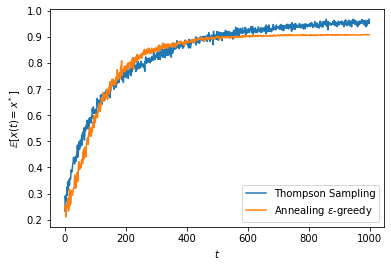

In [16]:
plt.tight_layout()
plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label=r'Thompson Sampling')
plt.plot(np.mean(arms_aeg == Env.opt(), axis=0), label=r'Annealing $\epsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.savefig(path_fig + "result_thompson_sampling.png", bbox_inches="tight")
plt.show()

### UCB Algorithms

In [17]:
class UCBAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0 for _ in range(n_arms)]
        
    def calc_ucb(self, arm):
        ucb = self.values[arm]
        ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb
        
    def get_arm(self):
        # 一回も選択されていない腕があればそれを選ぶ
        if 0 in self.counts:
            arm = self.counts.index(0)
        else:
            ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
            arm = ucb.index(max(ucb))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [18]:
arms_ucb, rewards_ucb = sim(UCBAgent)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.99it/s]


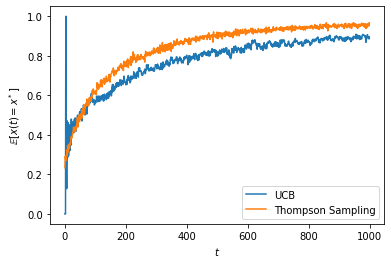

In [19]:
plt.plot(np.mean(arms_ucb == Env.opt(), axis=0), label=r'UCB')
plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label=r'Thompson Sampling')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.savefig(path_fig + "result_ucb.png", bbox_inches="tight")
plt.show()

## 特徴量を考慮する

### 環境の設定

In [7]:
arms = [[0,0], [0,1], [1,0], [1,1]]
# 4番目の腕[1,1]が最適
class Env(object):
    def p(arm):
        x = arm[0]*0.2 + arm[1]*0.8 - 4
        return 1 / (1+np.exp(-x))
    
    def react(arm):
        return 1 if np.random.random() < Env.p(arm) else 0
    
    def opt():
        return np.argmax([Env.p(arm) for arm in arms])

### Lin UCB

In [8]:
# 逆行列の計算をウッドベリーの公式を用いて短縮
class LinUCBAgent(object):
    def __init__(self, alpha=1, sigma=1):
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
        self.alpha = alpha
        self.sigma = sigma
        self.inv_A = np.identity(self.phis.shape[0])
        self.b = np.zeros((self.phis.shape[0],1))
        self.counts = [0 for _ in range(n_arms)]
        
    def get_arm(self):
        post_mean = self.inv_A.dot(self.b)
        post_var = self.inv_A
        pred_mean = self.phis.T.dot(post_mean)
        pred_var = self.phis.T.dot(post_var).dot(self.phis)
        ucb = pred_mean.T + self.alpha * np.sqrt(np.diag(pred_var))
        return np.argmax(ucb)
    
    def sample(self, arm_index, reward):
        phi = self.phis[:, [arm_index]]
        iAppTiA = self.inv_A.dot(phi).dot(phi.T).dot(self.inv_A)
        s2_pTiAp = self.sigma ** 2 + phi.T.dot(self.inv_A).dot(phi)
        self.inv_A = self.inv_A - iAppTiA / s2_pTiAp
        self.b += phi * reward * (self.sigma ** 2)
        self.counts[arm_index] += 1

In [9]:
n_iter = 500
n_step = 5000
selected_arms_linucb = np.zeros((n_iter, n_step), dtype=int)
earned_rewards_linucb = np.zeros((n_iter, n_step), dtype=int)
for it in tqdm(range(n_iter)):
    agent = LinUCBAgent()
    for step in range(n_step):
        arm_index = agent.get_arm()
        reward = Env.react(arms[arm_index])
        agent.sample(arm_index, reward)
        selected_arms_linucb[it, step] = arm_index
        earned_rewards_linucb[it, step] = reward

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.55it/s]


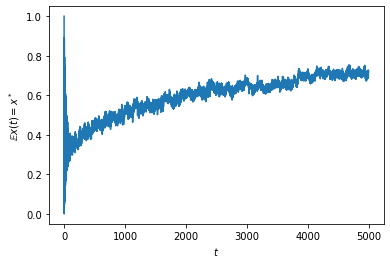

In [10]:
plt.plot(np.mean(selected_arms_linucb==Env.opt(), axis=0))
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}{x(t) = x^*}$')
plt.savefig(path_fig + "result_linucb.png", bbox_inches="tight")
plt.show()

### Compare with normal UCB

In [11]:
class UCBAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0 for _ in range(n_arms)]
        
    def calc_ucb(self, arm):
        ucb = self.values[arm]
        ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb
        
    def get_arm(self):
        # 一回も選択されていない腕があればそれを選ぶ
        if 0 in self.counts:
            arm = self.counts.index(0)
        else:
            ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
            arm = ucb.index(max(ucb))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [12]:
agent_classes = [LinUCBAgent, UCBAgent]
n_arms = len(arms)
n_iter = 500
n_step = 5000
selected_arms = np.zeros((n_iter, len(agent_classes), n_step), dtype=int)
earned_rewards = np.zeros((n_iter, len(agent_classes), n_step), dtype=int)

In [13]:
for it in tqdm(range(n_iter)):
    for i, agent_class in enumerate(agent_classes):
        agent = agent_class()
        for step in range(n_step):
            arm_index = agent.get_arm()
            arm = arms[arm_index]
            reward = Env.react(arm)
            agent.sample(arm_index, reward)
            selected_arms[it, i, step] = arm_index
            earned_rewards[it, i, step] = reward

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.94it/s]


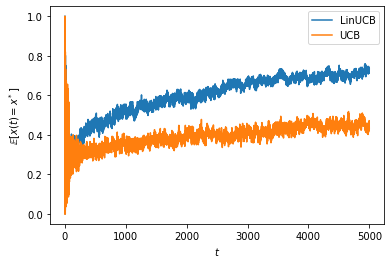

In [14]:
acc = np.mean(selected_arms==Env.opt(), axis=0)
plt.plot(acc[0], label='LinUCB')
plt.plot(acc[1], label='UCB')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t)=x^*]$')
plt.legend()
plt.savefig(path_fig + "compare_ucb_vs_linucb.png", bbox_inches="tight")
plt.show()

### Logistic Thompson Sampling

In [15]:
# LogisticTSアルゴリズムのクラス
class LogisticTSAgent:
    """
    Args :
        sigma_0(float)             : theta の事前分布の分散
        num_theta_max_iter(int)    : theta の探索を行う反復回数の上限
        epsilon(float)             : theta の探索を行う際の収束許容誤差
        interval_update_theta(int) : thetaの更新を行う間隔. この回数だけ反復したら theta, hessian を更新する
    """
    def __init__(self, sigma_0=0.1, num_theta_max_iter=1000, epsilon=0.01, interval_update_theta=100):
        self.sigma_0 = sigma_0
        self.num_theta_max_iter = num_theta_max_iter
        self.epsilon = epsilon
        self.interval_update_theta = interval_update_theta
    
    def initialize(self, n_features):
        """環境の初期化関数
        
        Args:
            n_features(int) : 文脈の次元数
            
        Attributes:
            theta(np.array)                     : 各特徴量に対するパラメータ
            iter_num(int)                       : 現在の反復回数
            lst_context_history(list[np.array]) : 引いた腕のcontextリスト
            lst_reward_history(list[int])       : 引いた腕の報酬リスト. 0 or 1
            H_inv(np.array)                     : 乱数生成に必要なヘシアンの逆行列
        """
        self.n_features = n_features
        self.theta  = np.zeros(n_features)
        
        self.iter_num = 0
        self.lst_context_history = []
        self.lst_reward_history = []
        self.H_inv = self.calc_hessian_inv(self.theta)
        return
    
    def logistic(self, x):
        """logistic 関数
        
        xが小さすぎるとオーバーフローを起こすため、-500より小さければ0とする
        """
        if x < -500:
            return 0
        else:
            return 1 / (1+np.exp(-x))
        
    def calc_gradient(self, theta):
        """負の対数事後確率の勾配 g(θ) の計算"""
        g = (theta / self.sigma_0**2)

        for idx, context in enumerate(self.lst_context_history):
            g += context * (self.logistic(theta.dot(context)) - self.lst_reward_history[idx])
        
        return g
    
    def calc_hessian_inv(self, theta):
        """負の対数事後確率のヘシアン H(θ) の逆行列の計算"""
        H = (np.identity(self.n_features)/self.sigma_0**2)

        for context in self.lst_context_history:
            val_logistic = self.logistic(theta.dot(context))
            H += context.dot(context.T) * val_logistic * (1 - val_logistic)

        return np.linalg.inv(H)
        
    def set_theta(self, theta):
        """theta の係数格納"""
        self.theta = theta
        return
    
    def set_H_inv(self, H_inv):
        """乱数生成に必要なヘシアンの逆行列格納"""
        self.H_inv = H_inv
        return
        
    def get_theta_by_normalDistribution(self):
        """多変量正規分布からパラメータをサンプリング"""
        return np.random.multivariate_normal(self.theta, self.H_inv)
    
    def get_arm(self, context):
        """腕を選択
        
        Args:
            context(np.array) : 特徴量. 次元は、(腕の数)×（特徴量の数）
        """
        np_context = np.array(context)
        theta_tild = self.get_theta_by_normalDistribution()
        
        score = np_context.dot(theta_tild)
        return np.argmax(score)
        
    def add_reward(self, reward):
        """得られた報酬のリストに追加"""
        self.lst_reward_history.append(reward)
        return
        
    def add_context(self, context):
        """選択した腕のcontextをリストに追加"""
        self.lst_context_history.append(np.array(context))
        return
    
    def update_theta(self):
        """観測した報酬からtheta更新"""
        theta_hat = self.theta
        
        # thetaが収束するか規定回数を反復するまで計算する
        for i in range(self.num_theta_max_iter):
            theta_before = theta_hat
            g = self.calc_gradient(theta_hat)
            H_inv = self.calc_hessian_inv(theta_hat)
            
            theta_hat = theta_hat - H_inv.dot(g)
            
            # 収束したら終了
            ## 収束しなかったらthetaを更新して再計算
            if np.linalg.norm(theta_hat - theta_before) < self.epsilon:
                break
                
        # 規定回数までに収束しなかったら表示
        if i == self.num_theta_max_iter-1:
            print("max iter over")
            
        # 収束したら更新
        self.set_theta(theta_hat)
        self.set_H_inv(self.calc_hessian_inv(theta_hat))
        return 
    
    def sample(self, context, reward):
        """選択した腕の文脈とその報酬を得て、更新を行う"""
        self.iter_num += 1
        self.add_reward(reward)
        self.add_context(context)
        # 設定した更新間隔に達していればthetaを更新する
        if self.iter_num % self.interval_update_theta == 0:
            self.update_theta()

In [20]:
from joblib import Parallel, delayed

In [21]:
n_step = 5000
features = np.array([[arm[0], arm[1], 1] for arm in arms])

def sim():
    agent = LogisticTSAgent()
    agent.initialize(n_arms=len(arms), n_features=len(features[0]), sigma=1)
    selected_arms = []
    earned_rewards = []
    for step in range(n_step):
        arm_index = agent.get_arm(features)
        reward = Env.react(arms[arm_index])
        agent.sample(features[arm_index], reward)
        selected_arms.append(arm_index)
        earned_rewards.append(reward)
    return (selected_arms, earned_rewards)

In [ ]:
n_iter = 500

results = Parallel(n_jobs=-1)([
    delayed(sim)() for _ in range(n_iter)
])

selected_arms_logisticTS = np.array([i[0] for i in results])
earned_rewards_logisticTS = np.array([i[1] for i in results])

In [ ]:
plt.plot(np.mean(selected_arms_logisticTS==Env.opt(), axis=0), label=r'Logistic Thompson Sampling')
plt.plot(np.mean(selected_arms_linucb==Env.opt(), axis=0), label=r'LinUCB')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}{x(t) = x^*}$')
plt.legend()
plt.savefig(path_fig + "result_logistic_TS.png", bbox_inches="tight")
plt.show()

## 触るな危険

### Logistic Thompson Sampling

In [28]:
class MCMC_GLMTSAgent(object):
    def __init__(self):
        self.counts = [0 for _ in arms]
        self.wins = [0 for _ in arms]
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
        
    def get_arm(self):
        if 0 in self.counts: return self.counts.index(0)
        with pm.Model() as model:
            w = pm.Normal('w', mu=0, sigma=10, shape=3)
            linpred = pm.math.dot(w, self.phis)
            theta = pm.Deterministic(
                'theta', 1/(1+pm.math.exp(linpred))
            )
            obs = pm.Binomial(
                'obs', n=self.counts, p=theta, observed=self.wins
            )
            trace = pm.sample(2000, chains=1)
        sample = pm.sample_posterior_predictive(
            trace, samples=1, model=model, vars=[theta]
        )
        return np.argmax(sample['theta'])
    
    def sample(self, arm_index, reward):
        self.counts[arm_index] += 1
        self.wins[arm_index] += reward

In [30]:
# simulation
n_step = 1000
n_iter = 50
selected_arms_logisticTS = np.zeros((n_iter, n_step), dtype=int)
earned_rewards_logisticTS = np.zeros((n_iter, n_step), dtype=int)
agent = MCMC_GLMTSAgent()
for step in tqdm(range(n_step)):
    arm_index = agent.get_arm()
    for it in range(n_iter):
        reward = Env.react(arms[arm_index])
        agent.sample(arm_index, reward)
        selected_arms_logisticTS[it, step] = arm_index
        earned_rewards_logisticTS[it, step] = reward

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\ideru\Anaconda3\envs\pymc3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


  0%|▍                                                                              | 5/1000 [00:19<1:05:28,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|▍                                                                              | 6/1000 [00:31<1:34:43,  5.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|▌                                                                              | 7/1000 [00:51<2:30:04,  9.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|▋                                                                              | 8/1000 [01:11<3:19:13, 12.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|▋                                                                              | 9/1000 [01:24<3:22:57, 12.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|▊                                                                             | 10/1000 [01:46<4:03:34, 14.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|▊                                                                             | 11/1000 [02:07<4:32:54, 16.56s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|▉                                                                             | 12/1000 [02:21<4:20:15, 15.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|█                                                                             | 13/1000 [02:40<4:36:37, 16.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  1%|█                                                                             | 14/1000 [02:54<4:22:38, 15.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▏                                                                            | 15/1000 [03:16<4:50:14, 17.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6394301723476499, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▏                                                                            | 16/1000 [03:36<5:04:19, 18.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▎                                                                            | 17/1000 [03:50<4:40:16, 17.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▍                                                                            | 18/1000 [04:09<4:48:43, 17.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▍                                                                            | 19/1000 [04:28<4:55:41, 18.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▌                                                                            | 20/1000 [04:42<4:36:27, 16.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▋                                                                            | 21/1000 [05:06<5:09:01, 18.94s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▋                                                                            | 22/1000 [05:22<4:56:10, 18.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8911542759823865, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▊                                                                            | 23/1000 [05:45<5:20:03, 19.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▊                                                                            | 24/1000 [06:08<5:34:46, 20.58s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  2%|█▉                                                                            | 25/1000 [06:23<5:08:12, 18.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██                                                                            | 26/1000 [06:44<5:15:34, 19.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8909324167094456, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██                                                                            | 27/1000 [07:07<5:31:47, 20.46s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.905327534609693, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██▏                                                                           | 28/1000 [07:22<5:06:42, 18.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
There were 444 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.536435968714288, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██▎                                                                           | 29/1000 [07:41<5:04:55, 18.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.881086756352528, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██▎                                                                           | 30/1000 [07:53<4:34:44, 16.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██▍                                                                           | 31/1000 [08:17<5:06:00, 18.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██▍                                                                           | 32/1000 [08:40<5:25:06, 20.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██▌                                                                           | 33/1000 [08:56<5:03:18, 18.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  3%|██▋                                                                           | 34/1000 [09:19<5:25:08, 20.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|██▋                                                                           | 35/1000 [09:39<5:22:17, 20.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6420101569395381, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|██▊                                                                           | 36/1000 [09:54<4:58:22, 18.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8890254514200887, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|██▉                                                                           | 37/1000 [10:18<5:26:16, 20.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8858617248200108, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|██▉                                                                           | 38/1000 [10:43<5:45:12, 21.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|███                                                                           | 39/1000 [10:59<5:19:52, 19.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|███                                                                           | 40/1000 [11:22<5:36:50, 21.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|███▏                                                                          | 41/1000 [11:46<5:46:05, 21.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|███▎                                                                          | 42/1000 [12:02<5:23:01, 20.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8982438493567393, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|███▎                                                                          | 43/1000 [12:26<5:40:40, 21.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8943612026888511, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|███▍                                                                          | 44/1000 [12:51<5:55:38, 22.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  4%|███▌                                                                          | 45/1000 [13:08<5:28:53, 20.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|███▌                                                                          | 46/1000 [13:30<5:35:12, 21.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8866893588667922, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|███▋                                                                          | 47/1000 [13:47<5:14:53, 19.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|███▋                                                                          | 48/1000 [14:10<5:31:48, 20.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|███▊                                                                          | 49/1000 [14:34<5:45:58, 21.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|███▉                                                                          | 50/1000 [14:52<5:24:25, 20.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|███▉                                                                          | 51/1000 [15:17<5:46:16, 21.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|████                                                                          | 52/1000 [15:38<5:43:17, 21.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8815034861140109, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|████▏                                                                         | 53/1000 [15:53<5:09:34, 19.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.889696328078341, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  5%|████▏                                                                         | 54/1000 [16:18<5:38:25, 21.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▎                                                                         | 55/1000 [16:36<5:21:23, 20.41s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▎                                                                         | 56/1000 [17:02<5:44:00, 21.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▍                                                                         | 57/1000 [17:23<5:42:43, 21.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▌                                                                         | 58/1000 [17:40<5:16:52, 20.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▌                                                                         | 59/1000 [18:05<5:42:17, 21.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▋                                                                         | 60/1000 [18:31<5:57:55, 22.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▊                                                                         | 61/1000 [18:47<5:26:44, 20.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8835317930960951, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▊                                                                         | 62/1000 [19:14<5:53:19, 22.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▉                                                                         | 63/1000 [19:38<6:00:12, 23.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|████▉                                                                         | 64/1000 [19:56<5:37:15, 21.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.894653005484645, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  6%|█████                                                                         | 65/1000 [20:19<5:42:02, 21.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8979883648904482, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▏                                                                        | 66/1000 [20:34<5:09:28, 19.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▏                                                                        | 67/1000 [20:58<5:30:43, 21.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▎                                                                        | 68/1000 [21:24<5:49:16, 22.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▍                                                                        | 69/1000 [21:40<5:21:16, 20.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▍                                                                        | 70/1000 [22:06<5:44:08, 22.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▌                                                                        | 71/1000 [22:31<5:56:15, 23.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▌                                                                        | 72/1000 [22:48<5:31:09, 21.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▋                                                                        | 73/1000 [23:13<5:45:53, 22.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  7%|█████▊                                                                        | 74/1000 [23:38<5:56:06, 23.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|█████▊                                                                        | 75/1000 [23:56<5:32:13, 21.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|█████▉                                                                        | 76/1000 [24:21<5:50:19, 22.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████                                                                        | 77/1000 [24:46<6:00:39, 23.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████                                                                        | 78/1000 [25:03<5:29:39, 21.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████▏                                                                       | 79/1000 [25:29<5:48:55, 22.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████▏                                                                       | 80/1000 [25:53<5:55:37, 23.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████▎                                                                       | 81/1000 [26:10<5:27:01, 21.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████▍                                                                       | 82/1000 [26:37<5:50:25, 22.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████▍                                                                       | 83/1000 [27:03<6:04:25, 23.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████▌                                                                       | 84/1000 [27:21<5:38:21, 22.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  8%|██████▋                                                                       | 85/1000 [27:48<5:58:34, 23.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
There were 422 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4466462230395722, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|██████▋                                                                       | 86/1000 [28:07<5:37:37, 22.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.9043635887708776, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|██████▊                                                                       | 87/1000 [28:25<5:21:49, 21.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|██████▊                                                                       | 88/1000 [28:48<5:29:15, 21.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|██████▉                                                                       | 89/1000 [29:07<5:13:44, 20.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|███████                                                                       | 90/1000 [29:33<5:38:10, 22.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5113608209580895, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|███████                                                                       | 91/1000 [29:54<5:34:30, 22.08s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|███████▏                                                                      | 92/1000 [30:13<5:19:34, 21.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5754987011744149, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|███████▎                                                                      | 93/1000 [30:36<5:29:04, 21.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


  9%|███████▎                                                                      | 94/1000 [31:01<5:40:32, 22.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.886418077716133, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▍                                                                      | 95/1000 [31:20<5:26:18, 21.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▍                                                                      | 96/1000 [31:47<5:50:13, 23.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▌                                                                      | 97/1000 [32:14<6:03:50, 24.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▋                                                                      | 98/1000 [32:30<5:26:25, 21.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▋                                                                      | 99/1000 [32:56<5:49:05, 23.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▋                                                                     | 100/1000 [33:20<5:48:50, 23.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▊                                                                     | 101/1000 [33:38<5:26:20, 21.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▊                                                                     | 102/1000 [34:05<5:49:17, 23.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|███████▉                                                                     | 103/1000 [34:28<5:45:48, 23.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|████████                                                                     | 104/1000 [34:47<5:27:22, 21.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 10%|████████                                                                     | 105/1000 [35:13<5:47:52, 23.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▏                                                                    | 106/1000 [35:38<5:54:21, 23.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8989502153112549, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▏                                                                    | 107/1000 [35:58<5:37:24, 22.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▎                                                                    | 108/1000 [36:22<5:41:42, 22.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▍                                                                    | 109/1000 [36:42<5:27:43, 22.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▍                                                                    | 110/1000 [37:10<5:53:01, 23.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▌                                                                    | 111/1000 [37:34<5:56:18, 24.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▌                                                                    | 112/1000 [37:49<5:15:54, 21.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▋                                                                    | 113/1000 [38:15<5:36:12, 22.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 11%|████████▊                                                                    | 114/1000 [38:43<5:56:05, 24.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|████████▊                                                                    | 115/1000 [39:03<5:37:36, 22.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|████████▉                                                                    | 116/1000 [39:31<6:00:12, 24.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████                                                                    | 117/1000 [39:58<6:12:31, 25.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████                                                                    | 118/1000 [40:18<5:47:34, 23.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████▏                                                                   | 119/1000 [40:45<6:04:07, 24.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████▏                                                                   | 120/1000 [41:13<6:14:23, 25.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████▎                                                                   | 121/1000 [41:29<5:33:09, 22.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████▍                                                                   | 122/1000 [41:56<5:53:31, 24.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████▍                                                                   | 123/1000 [42:12<5:17:12, 21.70s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████▌                                                                   | 124/1000 [42:37<5:30:03, 22.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.9087211840591402, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 12%|█████████▋                                                                   | 125/1000 [43:02<5:40:05, 23.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|█████████▋                                                                   | 126/1000 [43:20<5:15:40, 21.67s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.903720456784936, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|█████████▊                                                                   | 127/1000 [43:48<5:44:28, 23.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|█████████▊                                                                   | 128/1000 [44:14<5:54:12, 24.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|█████████▉                                                                   | 129/1000 [44:34<5:34:44, 23.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|██████████                                                                   | 130/1000 [45:02<5:56:38, 24.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|██████████                                                                   | 131/1000 [45:31<6:13:51, 25.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|██████████▏                                                                  | 132/1000 [45:50<5:45:01, 23.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|██████████▏                                                                  | 133/1000 [46:19<6:03:38, 25.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8800467507637462, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 13%|██████████▎                                                                  | 134/1000 [46:47<6:15:42, 26.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▍                                                                  | 135/1000 [47:02<5:29:35, 22.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▍                                                                  | 136/1000 [47:30<5:50:53, 24.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▌                                                                  | 137/1000 [47:47<5:19:32, 22.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9016297037179538, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▋                                                                  | 138/1000 [48:16<5:49:40, 24.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▋                                                                  | 139/1000 [48:45<6:06:25, 25.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▊                                                                  | 140/1000 [49:01<5:25:45, 22.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8887951535320687, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▊                                                                  | 141/1000 [49:29<5:50:00, 24.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.9011111486314936, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|██████████▉                                                                  | 142/1000 [49:58<6:05:52, 25.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|███████████                                                                  | 143/1000 [50:17<5:39:10, 23.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|███████████                                                                  | 144/1000 [50:44<5:50:40, 24.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 14%|███████████▏                                                                 | 145/1000 [51:11<6:02:04, 25.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▏                                                                 | 146/1000 [51:28<5:26:12, 22.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8804011955200043, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▎                                                                 | 147/1000 [51:58<5:56:48, 25.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▍                                                                 | 148/1000 [52:26<6:09:09, 26.00s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▍                                                                 | 149/1000 [52:47<5:44:01, 24.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▌                                                                 | 150/1000 [53:13<5:54:46, 25.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▋                                                                 | 151/1000 [53:42<6:09:38, 26.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▋                                                                 | 152/1000 [54:03<5:46:35, 24.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▊                                                                 | 153/1000 [54:32<6:05:25, 25.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 15%|███████████▊                                                                 | 154/1000 [54:58<6:06:01, 25.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|███████████▉                                                                 | 155/1000 [55:19<5:42:24, 24.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████                                                                 | 156/1000 [55:47<6:01:20, 25.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████                                                                 | 157/1000 [56:14<6:03:51, 25.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▏                                                                | 158/1000 [56:34<5:38:11, 24.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.9045601456975134, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▏                                                                | 159/1000 [57:03<5:58:56, 25.61s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▎                                                                | 160/1000 [57:31<6:08:06, 26.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▍                                                                | 161/1000 [57:59<6:16:51, 26.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▍                                                                | 162/1000 [58:21<5:52:28, 25.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▌                                                                | 163/1000 [58:47<5:57:47, 25.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▋                                                                | 164/1000 [59:06<5:29:31, 23.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9012062972059675, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 16%|████████████▋                                                                | 165/1000 [59:36<5:55:05, 25.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8847999170271658, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▍                                                              | 166/1000 [1:00:05<6:10:18, 26.64s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▌                                                              | 167/1000 [1:00:33<6:13:43, 26.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▌                                                              | 168/1000 [1:00:56<5:56:58, 25.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9025265796057448, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▋                                                              | 169/1000 [1:01:25<6:12:26, 26.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▊                                                              | 170/1000 [1:01:54<6:19:56, 27.47s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▊                                                              | 171/1000 [1:02:15<5:53:54, 25.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▉                                                              | 172/1000 [1:02:42<5:57:04, 25.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|████████████▉                                                              | 173/1000 [1:03:09<6:01:52, 26.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9075932858606262, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 17%|█████████████                                                              | 174/1000 [1:03:31<5:42:21, 24.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▏                                                             | 175/1000 [1:04:01<6:02:50, 26.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▏                                                             | 176/1000 [1:04:30<6:14:18, 27.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▎                                                             | 177/1000 [1:04:52<5:50:25, 25.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9036190070234018, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▎                                                             | 178/1000 [1:05:21<6:07:58, 26.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▍                                                             | 179/1000 [1:05:52<6:20:46, 27.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▌                                                             | 180/1000 [1:06:14<5:58:31, 26.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▌                                                             | 181/1000 [1:06:46<6:21:15, 27.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▋                                                             | 182/1000 [1:07:15<6:24:28, 28.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▋                                                             | 183/1000 [1:07:37<5:59:12, 26.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▊                                                             | 184/1000 [1:08:05<6:07:09, 27.00s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8957741010852135, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 18%|█████████████▉                                                             | 185/1000 [1:08:35<6:18:14, 27.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|█████████████▉                                                             | 186/1000 [1:08:58<5:57:14, 26.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████                                                             | 187/1000 [1:09:28<6:10:28, 27.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████                                                             | 188/1000 [1:09:58<6:23:36, 28.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9009084726065661, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████▏                                                            | 189/1000 [1:10:20<5:56:35, 26.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████▎                                                            | 190/1000 [1:10:51<6:15:22, 27.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████▎                                                            | 191/1000 [1:11:20<6:20:03, 28.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.886949941662764, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████▍                                                            | 192/1000 [1:11:51<6:27:42, 28.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████▍                                                            | 193/1000 [1:12:11<5:52:14, 26.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 19%|██████████████▌                                                            | 194/1000 [1:12:41<6:08:48, 27.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|██████████████▋                                                            | 195/1000 [1:13:11<6:18:31, 28.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|██████████████▋                                                            | 196/1000 [1:13:33<5:52:15, 26.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|██████████████▊                                                            | 197/1000 [1:14:01<6:00:59, 26.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|██████████████▊                                                            | 198/1000 [1:14:33<6:19:32, 28.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5335921459189965, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|██████████████▉                                                            | 199/1000 [1:14:49<5:29:41, 24.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|███████████████                                                            | 200/1000 [1:15:19<5:50:57, 26.32s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|███████████████                                                            | 201/1000 [1:15:51<6:10:12, 27.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|███████████████▏                                                           | 202/1000 [1:16:12<5:46:06, 26.02s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|███████████████▏                                                           | 203/1000 [1:16:42<5:58:04, 26.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|███████████████▎                                                           | 204/1000 [1:17:12<6:09:52, 27.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8823389230137031, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 20%|███████████████▎                                                           | 205/1000 [1:17:43<6:21:52, 28.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▍                                                           | 206/1000 [1:18:06<5:58:27, 27.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▌                                                           | 207/1000 [1:18:37<6:13:17, 28.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▌                                                           | 208/1000 [1:19:06<6:16:52, 28.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▋                                                           | 209/1000 [1:19:30<5:57:00, 27.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▊                                                           | 210/1000 [1:20:00<6:11:34, 28.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▊                                                           | 211/1000 [1:20:32<6:22:58, 29.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▉                                                           | 212/1000 [1:20:57<6:06:37, 27.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|███████████████▉                                                           | 213/1000 [1:21:29<6:21:48, 29.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 21%|████████████████                                                           | 214/1000 [1:22:00<6:30:46, 29.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▏                                                          | 215/1000 [1:22:25<6:08:50, 28.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▏                                                          | 216/1000 [1:22:57<6:23:32, 29.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▎                                                          | 217/1000 [1:23:29<6:34:09, 30.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▎                                                          | 218/1000 [1:23:52<6:06:00, 28.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5180226968762905, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▍                                                          | 219/1000 [1:24:17<5:52:19, 27.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 401 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49002415896004065, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▌                                                          | 220/1000 [1:24:40<5:39:28, 26.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▌                                                          | 221/1000 [1:25:04<5:27:11, 25.20s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▋                                                          | 222/1000 [1:25:36<5:54:27, 27.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▋                                                          | 223/1000 [1:26:07<6:08:32, 28.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▊                                                          | 224/1000 [1:26:38<6:19:41, 29.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 22%|████████████████▉                                                          | 225/1000 [1:27:03<6:00:50, 27.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|████████████████▉                                                          | 226/1000 [1:27:34<6:10:37, 28.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████                                                          | 227/1000 [1:28:00<6:00:18, 27.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████                                                          | 228/1000 [1:28:22<5:38:45, 26.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████▏                                                         | 229/1000 [1:28:52<5:51:36, 27.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████▎                                                         | 230/1000 [1:29:23<6:05:11, 28.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████▎                                                         | 231/1000 [1:29:47<5:45:34, 26.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████▍                                                         | 232/1000 [1:30:18<6:03:53, 28.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8831548827313688, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████▍                                                         | 233/1000 [1:30:51<6:21:12, 29.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 23%|█████████████████▌                                                         | 234/1000 [1:31:11<5:41:53, 26.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|█████████████████▋                                                         | 235/1000 [1:31:43<5:59:47, 28.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.538546665712747, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|█████████████████▋                                                         | 236/1000 [1:32:07<5:45:52, 27.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|█████████████████▊                                                         | 237/1000 [1:32:31<5:30:16, 25.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|█████████████████▊                                                         | 238/1000 [1:33:00<5:43:05, 27.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|█████████████████▉                                                         | 239/1000 [1:33:33<6:04:19, 28.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8819244785875137, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|██████████████████                                                         | 240/1000 [1:33:57<5:47:23, 27.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8898918548940298, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|██████████████████                                                         | 241/1000 [1:34:31<6:09:25, 29.20s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|██████████████████▏                                                        | 242/1000 [1:35:02<6:19:08, 30.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 5 seconds.
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.499986377315623, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|██████████████████▏                                                        | 243/1000 [1:35:19<5:27:27, 25.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|██████████████████▎                                                        | 244/1000 [1:35:48<5:39:23, 26.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5462204901663359, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 24%|██████████████████▍                                                        | 245/1000 [1:36:13<5:30:28, 26.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▍                                                        | 246/1000 [1:36:37<5:22:18, 25.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▌                                                        | 247/1000 [1:37:11<5:51:31, 28.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▌                                                        | 248/1000 [1:37:43<6:06:57, 29.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▋                                                        | 249/1000 [1:38:15<6:19:16, 30.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▊                                                        | 250/1000 [1:38:41<6:01:13, 28.90s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.9045448666088335, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▊                                                        | 251/1000 [1:39:13<6:13:17, 29.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▉                                                        | 252/1000 [1:39:46<6:22:15, 30.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|██████████████████▉                                                        | 253/1000 [1:40:11<6:02:15, 29.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 25%|███████████████████                                                        | 254/1000 [1:40:44<6:16:16, 30.26s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▏                                                       | 255/1000 [1:41:15<6:16:44, 30.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▏                                                       | 256/1000 [1:41:38<5:49:07, 28.16s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▎                                                       | 257/1000 [1:42:11<6:08:52, 29.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▎                                                       | 258/1000 [1:42:43<6:15:51, 30.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▍                                                       | 259/1000 [1:43:17<6:29:34, 31.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5049436241929508, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▌                                                       | 260/1000 [1:43:34<5:34:05, 27.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▌                                                       | 261/1000 [1:44:09<6:01:56, 29.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▋                                                       | 262/1000 [1:44:38<6:01:42, 29.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8816150427539056, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▋                                                       | 263/1000 [1:45:02<5:40:51, 27.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▊                                                       | 264/1000 [1:45:33<5:50:40, 28.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 26%|███████████████████▉                                                       | 265/1000 [1:46:07<6:10:29, 30.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|███████████████████▉                                                       | 266/1000 [1:46:33<5:55:39, 29.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████                                                       | 267/1000 [1:47:06<6:07:47, 30.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████                                                       | 268/1000 [1:47:38<6:14:23, 30.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████▏                                                      | 269/1000 [1:48:11<6:22:58, 31.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████▎                                                      | 270/1000 [1:48:35<5:54:10, 29.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████▎                                                      | 271/1000 [1:49:08<6:10:31, 30.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████▍                                                      | 272/1000 [1:49:41<6:19:08, 31.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████▍                                                      | 273/1000 [1:50:06<5:55:26, 29.34s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 27%|████████████████████▌                                                      | 274/1000 [1:50:40<6:10:36, 30.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.7198560213287122, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|████████████████████▋                                                      | 275/1000 [1:51:12<6:15:08, 31.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6128149383989236, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|████████████████████▋                                                      | 276/1000 [1:51:32<5:34:23, 27.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|████████████████████▊                                                      | 277/1000 [1:52:06<5:55:30, 29.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|████████████████████▊                                                      | 278/1000 [1:52:38<6:06:04, 30.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.9122961309546883, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|████████████████████▉                                                      | 279/1000 [1:53:11<6:15:49, 31.28s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5864383373219116, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|█████████████████████                                                      | 280/1000 [1:53:30<5:30:56, 27.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|█████████████████████                                                      | 281/1000 [1:54:04<5:52:04, 29.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|█████████████████████▏                                                     | 282/1000 [1:54:38<6:10:03, 30.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|█████████████████████▏                                                     | 283/1000 [1:55:04<5:49:07, 29.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5432621181895756, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|█████████████████████▎                                                     | 284/1000 [1:55:30<5:38:06, 28.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 28%|█████████████████████▎                                                     | 285/1000 [1:56:03<5:53:31, 29.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▍                                                     | 286/1000 [1:56:36<6:07:47, 30.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▌                                                     | 287/1000 [1:56:58<5:34:19, 28.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▌                                                     | 288/1000 [1:57:30<5:47:38, 29.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▋                                                     | 289/1000 [1:58:02<5:54:59, 29.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▊                                                     | 290/1000 [1:58:28<5:43:11, 29.00s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▊                                                     | 291/1000 [1:59:02<5:59:48, 30.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▉                                                     | 292/1000 [1:59:36<6:10:36, 31.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|█████████████████████▉                                                     | 293/1000 [2:00:02<5:50:45, 29.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 29%|██████████████████████                                                     | 294/1000 [2:00:36<6:07:06, 31.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▏                                                    | 295/1000 [2:01:11<6:17:54, 32.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▏                                                    | 296/1000 [2:01:44<6:21:46, 32.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▎                                                    | 297/1000 [2:02:11<6:00:04, 30.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▎                                                    | 298/1000 [2:02:44<6:09:44, 31.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▍                                                    | 299/1000 [2:03:19<6:20:04, 32.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▌                                                    | 300/1000 [2:03:43<5:49:39, 29.97s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8861812650945435, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▌                                                    | 301/1000 [2:04:15<5:55:33, 30.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▋                                                    | 302/1000 [2:04:50<6:10:37, 31.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▋                                                    | 303/1000 [2:05:15<5:46:34, 29.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▊                                                    | 304/1000 [2:05:50<6:03:11, 31.31s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|██████████████████████▉                                                    | 305/1000 [2:06:24<6:13:16, 32.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|██████████████████████▉                                                    | 306/1000 [2:07:00<6:24:18, 33.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████                                                    | 307/1000 [2:07:25<5:57:26, 30.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████                                                    | 308/1000 [2:07:58<6:04:32, 31.61s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████▏                                                   | 309/1000 [2:08:33<6:13:02, 32.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8808721615316049, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████▎                                                   | 310/1000 [2:08:58<5:47:31, 30.22s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████▎                                                   | 311/1000 [2:09:34<6:07:10, 31.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████▍                                                   | 312/1000 [2:10:03<5:56:36, 31.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8927261988871986, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████▍                                                   | 313/1000 [2:10:26<5:29:44, 28.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 31%|███████████████████████▌                                                   | 314/1000 [2:11:01<5:48:06, 30.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|███████████████████████▋                                                   | 315/1000 [2:11:32<5:50:55, 30.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|███████████████████████▋                                                   | 316/1000 [2:11:58<5:32:21, 29.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|███████████████████████▊                                                   | 317/1000 [2:12:32<5:50:54, 30.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|███████████████████████▊                                                   | 318/1000 [2:13:08<6:05:58, 32.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.9054670358279957, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|███████████████████████▉                                                   | 319/1000 [2:13:43<6:16:19, 33.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|████████████████████████                                                   | 320/1000 [2:14:09<5:51:48, 31.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.9088484423379514, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|████████████████████████                                                   | 321/1000 [2:14:43<6:00:42, 31.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|████████████████████████▏                                                  | 322/1000 [2:15:17<6:06:38, 32.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|████████████████████████▏                                                  | 323/1000 [2:15:40<5:33:52, 29.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|████████████████████████▎                                                  | 324/1000 [2:16:14<5:48:24, 30.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 32%|████████████████████████▍                                                  | 325/1000 [2:16:48<5:58:05, 31.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▍                                                  | 326/1000 [2:17:21<6:04:19, 32.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▌                                                  | 327/1000 [2:17:46<5:38:05, 30.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▌                                                  | 328/1000 [2:18:21<5:53:28, 31.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▋                                                  | 329/1000 [2:18:56<6:03:35, 32.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▊                                                  | 330/1000 [2:19:19<5:30:07, 29.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▊                                                  | 331/1000 [2:19:54<5:49:26, 31.34s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▉                                                  | 332/1000 [2:20:26<5:51:41, 31.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|████████████████████████▉                                                  | 333/1000 [2:20:51<5:29:01, 29.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 33%|█████████████████████████                                                  | 334/1000 [2:21:26<5:46:00, 31.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▏                                                 | 335/1000 [2:22:02<5:59:52, 32.47s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▏                                                 | 336/1000 [2:22:27<5:37:26, 30.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▎                                                 | 337/1000 [2:22:56<5:30:07, 29.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▎                                                 | 338/1000 [2:23:32<5:49:01, 31.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5094848140408662, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▍                                                 | 339/1000 [2:23:58<5:31:06, 30.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▌                                                 | 340/1000 [2:24:24<5:16:38, 28.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▌                                                 | 341/1000 [2:25:00<5:39:24, 30.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▋                                                 | 342/1000 [2:25:32<5:45:16, 31.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▋                                                 | 343/1000 [2:25:56<5:19:28, 29.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8799677796651023, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▊                                                 | 344/1000 [2:26:32<5:39:13, 31.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 34%|█████████████████████████▊                                                 | 345/1000 [2:27:06<5:50:54, 32.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|█████████████████████████▉                                                 | 346/1000 [2:27:34<5:37:02, 30.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████                                                 | 347/1000 [2:28:08<5:46:06, 31.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████                                                 | 348/1000 [2:28:45<6:00:56, 33.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████▏                                                | 349/1000 [2:29:10<5:34:07, 30.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████▎                                                | 350/1000 [2:29:45<5:49:08, 32.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████▎                                                | 351/1000 [2:30:20<5:56:38, 32.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████▍                                                | 352/1000 [2:30:56<6:04:34, 33.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████▍                                                | 353/1000 [2:31:23<5:43:12, 31.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|██████████████████████████▌                                                | 354/1000 [2:31:58<5:54:00, 32.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|██████████████████████████▋                                                | 355/1000 [2:32:31<5:51:19, 32.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5673389707375258, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|██████████████████████████▋                                                | 356/1000 [2:32:49<5:04:32, 28.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|██████████████████████████▊                                                | 357/1000 [2:33:24<5:24:03, 30.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|██████████████████████████▊                                                | 358/1000 [2:33:58<5:35:59, 31.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|██████████████████████████▉                                                | 359/1000 [2:34:21<5:10:36, 29.07s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|███████████████████████████                                                | 360/1000 [2:34:55<5:25:38, 30.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|███████████████████████████                                                | 361/1000 [2:35:30<5:38:41, 31.80s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|███████████████████████████▏                                               | 362/1000 [2:36:07<5:53:36, 33.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8916905699661649, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|███████████████████████████▏                                               | 363/1000 [2:36:33<5:32:03, 31.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.9062682893102255, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|███████████████████████████▎                                               | 364/1000 [2:37:10<5:47:34, 32.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 36%|███████████████████████████▍                                               | 365/1000 [2:37:45<5:53:53, 33.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▍                                               | 366/1000 [2:38:12<5:33:44, 31.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▌                                               | 367/1000 [2:38:48<5:46:59, 32.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8893721521332261, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▌                                               | 368/1000 [2:39:24<5:56:25, 33.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▋                                               | 369/1000 [2:39:57<5:52:41, 33.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▊                                               | 370/1000 [2:40:23<5:30:03, 31.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▊                                               | 371/1000 [2:40:59<5:42:13, 32.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▉                                               | 372/1000 [2:41:34<5:50:42, 33.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|███████████████████████████▉                                               | 373/1000 [2:42:01<5:29:09, 31.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 37%|████████████████████████████                                               | 374/1000 [2:42:38<5:44:31, 33.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▏                                              | 375/1000 [2:43:08<5:36:31, 32.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▏                                              | 376/1000 [2:43:44<5:47:56, 33.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▎                                              | 377/1000 [2:44:13<5:30:58, 31.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▎                                              | 378/1000 [2:44:49<5:45:18, 33.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▍                                              | 379/1000 [2:45:26<5:55:22, 34.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▌                                              | 380/1000 [2:45:54<5:34:21, 32.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8894722090235427, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▌                                              | 381/1000 [2:46:32<5:51:58, 34.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▋                                              | 382/1000 [2:47:09<5:59:11, 34.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 12 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▋                                              | 383/1000 [2:47:42<5:52:56, 34.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▊                                              | 384/1000 [2:48:07<5:23:50, 31.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 38%|████████████████████████████▉                                              | 385/1000 [2:48:43<5:37:27, 32.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|████████████████████████████▉                                              | 386/1000 [2:49:19<5:45:45, 33.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████                                              | 387/1000 [2:49:43<5:15:53, 30.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████                                              | 388/1000 [2:50:20<5:34:45, 32.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9033649489279476, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████▏                                             | 389/1000 [2:50:57<5:47:12, 34.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9107265739596906, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████▎                                             | 390/1000 [2:51:27<5:32:54, 32.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.41278248846649457, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████▎                                             | 391/1000 [2:51:53<5:13:49, 30.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████▍                                             | 392/1000 [2:52:29<5:28:43, 32.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████▍                                             | 393/1000 [2:53:05<5:39:21, 33.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 39%|█████████████████████████████▌                                             | 394/1000 [2:53:33<5:19:28, 31.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|█████████████████████████████▋                                             | 395/1000 [2:54:10<5:36:42, 33.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|█████████████████████████████▋                                             | 396/1000 [2:54:44<5:37:23, 33.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|█████████████████████████████▊                                             | 397/1000 [2:55:21<5:47:19, 34.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|█████████████████████████████▊                                             | 398/1000 [2:55:48<5:22:53, 32.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|█████████████████████████████▉                                             | 399/1000 [2:56:21<5:27:18, 32.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|██████████████████████████████                                             | 400/1000 [2:56:55<5:28:41, 32.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|██████████████████████████████                                             | 401/1000 [2:57:23<5:14:14, 31.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 6 seconds.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4831001264173923, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|██████████████████████████████▏                                            | 402/1000 [2:57:47<4:50:24, 29.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9269323112098881, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|██████████████████████████████▏                                            | 403/1000 [2:58:24<5:14:42, 31.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|██████████████████████████████▎                                            | 404/1000 [2:58:51<5:00:24, 30.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9032555672888432, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|██████████████████████████████▍                                            | 405/1000 [2:59:29<5:23:39, 32.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▍                                            | 406/1000 [3:00:06<5:34:41, 33.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▌                                            | 407/1000 [3:00:42<5:41:00, 34.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▌                                            | 408/1000 [3:01:09<5:19:38, 32.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▋                                            | 409/1000 [3:01:45<5:28:02, 33.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▋                                            | 410/1000 [3:02:20<5:34:04, 33.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▊                                            | 411/1000 [3:02:47<5:12:21, 31.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8913985789296341, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▉                                            | 412/1000 [3:03:26<5:31:52, 33.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|██████████████████████████████▉                                            | 413/1000 [3:04:03<5:39:38, 34.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 41%|███████████████████████████████                                            | 414/1000 [3:04:38<5:42:25, 35.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5434641988265297, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▏                                           | 415/1000 [3:04:54<4:45:05, 29.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8915222896675539, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▏                                           | 416/1000 [3:05:31<5:06:45, 31.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▎                                           | 417/1000 [3:06:06<5:17:44, 32.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▎                                           | 418/1000 [3:06:34<5:02:18, 31.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▍                                           | 419/1000 [3:07:11<5:17:38, 32.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▌                                           | 420/1000 [3:07:48<5:30:40, 34.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▌                                           | 421/1000 [3:08:24<5:35:16, 34.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.89326915386681, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▋                                           | 422/1000 [3:08:53<5:16:37, 32.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▋                                           | 423/1000 [3:09:30<5:28:50, 34.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▊                                           | 424/1000 [3:10:08<5:38:40, 35.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9051301717355236, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 42%|███████████████████████████████▉                                           | 425/1000 [3:10:35<5:15:36, 32.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|███████████████████████████████▉                                           | 426/1000 [3:11:12<5:27:25, 34.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████                                           | 427/1000 [3:11:46<5:26:24, 34.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████                                           | 428/1000 [3:12:23<5:33:16, 34.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████▏                                          | 429/1000 [3:12:52<5:16:15, 33.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████▎                                          | 430/1000 [3:13:30<5:29:11, 34.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████▎                                          | 431/1000 [3:14:07<5:33:54, 35.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8821816101610448, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████▍                                          | 432/1000 [3:14:44<5:39:53, 35.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████▍                                          | 433/1000 [3:15:13<5:19:08, 33.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 43%|████████████████████████████████▌                                          | 434/1000 [3:15:50<5:25:44, 34.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8900866552032608, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|████████████████████████████████▋                                          | 435/1000 [3:16:24<5:24:55, 34.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|████████████████████████████████▋                                          | 436/1000 [3:16:47<4:52:58, 31.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|████████████████████████████████▊                                          | 437/1000 [3:17:25<5:11:55, 33.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|████████████████████████████████▊                                          | 438/1000 [3:18:00<5:14:02, 33.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|████████████████████████████████▉                                          | 439/1000 [3:18:27<4:55:55, 31.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|█████████████████████████████████                                          | 440/1000 [3:19:05<5:14:23, 33.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|█████████████████████████████████                                          | 441/1000 [3:19:40<5:15:30, 33.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8836139590856806, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|█████████████████████████████████▏                                         | 442/1000 [3:20:17<5:24:47, 34.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|█████████████████████████████████▏                                         | 443/1000 [3:20:45<5:04:06, 32.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|█████████████████████████████████▎                                         | 444/1000 [3:21:23<5:18:41, 34.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 44%|█████████████████████████████████▍                                         | 445/1000 [3:22:01<5:28:26, 35.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▍                                         | 446/1000 [3:22:39<5:33:29, 36.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8978939642698128, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▌                                         | 447/1000 [3:23:07<5:11:54, 33.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▌                                         | 448/1000 [3:23:45<5:22:13, 35.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9170520686150775, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▋                                         | 449/1000 [3:24:23<5:30:54, 36.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▊                                         | 450/1000 [3:25:02<5:37:50, 36.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▊                                         | 451/1000 [3:25:31<5:14:56, 34.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▉                                         | 452/1000 [3:26:09<5:25:03, 35.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████▉                                         | 453/1000 [3:26:47<5:30:42, 36.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|██████████████████████████████████                                         | 454/1000 [3:27:15<5:07:24, 33.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▏                                        | 455/1000 [3:27:53<5:18:30, 35.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▏                                        | 456/1000 [3:28:29<5:21:51, 35.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9039449538716863, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▎                                        | 457/1000 [3:29:08<5:29:04, 36.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▎                                        | 458/1000 [3:29:37<5:09:09, 34.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▍                                        | 459/1000 [3:30:16<5:20:05, 35.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▌                                        | 460/1000 [3:30:55<5:29:38, 36.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▌                                        | 461/1000 [3:31:34<5:36:50, 37.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9138080515930306, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▋                                        | 462/1000 [3:32:05<5:18:23, 35.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▋                                        | 463/1000 [3:32:46<5:31:36, 37.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▊                                        | 464/1000 [3:33:24<5:35:02, 37.51s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 46%|██████████████████████████████████▉                                        | 465/1000 [3:33:52<5:06:41, 34.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|██████████████████████████████████▉                                        | 466/1000 [3:34:30<5:16:40, 35.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9131851530853247, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████                                        | 467/1000 [3:35:10<5:26:45, 36.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████                                        | 468/1000 [3:35:45<5:21:45, 36.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████▏                                       | 469/1000 [3:36:14<5:03:11, 34.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8801734501880116, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████▎                                       | 470/1000 [3:36:53<5:15:25, 35.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████▎                                       | 471/1000 [3:37:31<5:19:15, 36.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████▍                                       | 472/1000 [3:38:10<5:26:17, 37.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████▍                                       | 473/1000 [3:38:39<5:05:27, 34.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 47%|███████████████████████████████████▌                                       | 474/1000 [3:39:17<5:13:09, 35.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|███████████████████████████████████▋                                       | 475/1000 [3:39:52<5:11:29, 35.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9103134608142975, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|███████████████████████████████████▋                                       | 476/1000 [3:40:35<5:28:31, 37.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|███████████████████████████████████▊                                       | 477/1000 [3:41:01<4:57:22, 34.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|███████████████████████████████████▊                                       | 478/1000 [3:41:40<5:09:47, 35.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|███████████████████████████████████▉                                       | 479/1000 [3:42:18<5:16:29, 36.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5505046637797699, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|████████████████████████████████████                                       | 480/1000 [3:42:37<4:31:07, 31.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|████████████████████████████████████                                       | 481/1000 [3:43:15<4:47:40, 33.26s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|████████████████████████████████████▏                                      | 482/1000 [3:43:53<4:59:17, 34.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8924396901618723, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|████████████████████████████████████▏                                      | 483/1000 [3:44:33<5:13:04, 36.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|████████████████████████████████████▎                                      | 484/1000 [3:45:03<4:55:21, 34.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 48%|████████████████████████████████████▍                                      | 485/1000 [3:45:40<5:01:15, 35.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▍                                      | 486/1000 [3:46:18<5:08:46, 36.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▌                                      | 487/1000 [3:46:58<5:17:09, 37.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▌                                      | 488/1000 [3:47:24<4:49:03, 33.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▋                                      | 489/1000 [3:48:01<4:55:30, 34.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▊                                      | 490/1000 [3:48:40<5:06:49, 36.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▊                                      | 491/1000 [3:49:19<5:14:04, 37.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▉                                      | 492/1000 [3:49:50<4:56:24, 35.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|████████████████████████████████████▉                                      | 493/1000 [3:50:27<5:02:01, 35.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 49%|█████████████████████████████████████                                      | 494/1000 [3:51:04<5:04:12, 36.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4811262198059675, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▏                                     | 495/1000 [3:51:33<4:46:12, 34.01s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5501922770910558, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▏                                     | 496/1000 [3:51:53<4:09:21, 29.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.7156971183042767, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▎                                     | 497/1000 [3:52:30<4:28:23, 32.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▎                                     | 498/1000 [3:53:08<4:43:37, 33.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▍                                     | 499/1000 [3:53:35<4:24:59, 31.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▌                                     | 500/1000 [3:54:14<4:41:01, 33.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▌                                     | 501/1000 [3:54:52<4:52:05, 35.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▋                                     | 502/1000 [3:55:30<4:59:17, 36.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8829995381860994, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▋                                     | 503/1000 [3:56:00<4:42:53, 34.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9054270566221951, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▊                                     | 504/1000 [3:56:40<4:56:24, 35.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████▉                                     | 505/1000 [3:57:19<5:04:41, 36.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8903860135025088, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|█████████████████████████████████████▉                                     | 506/1000 [3:58:01<5:16:26, 38.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.9047259676736307, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████                                     | 507/1000 [3:58:31<4:55:26, 35.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████                                     | 508/1000 [3:59:11<5:04:07, 37.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████▏                                    | 509/1000 [3:59:52<5:12:34, 38.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9044523765184167, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:00:32<5:15:57, 38.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.9040211687320098, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:01:01<4:51:42, 35.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6757521591354156, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:01:35<4:48:15, 35.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:02:14<4:54:48, 36.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:02:52<4:59:04, 36.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:03:23<4:44:27, 35.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:04:04<4:56:32, 36.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8951721153489495, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:04:44<5:04:34, 37.83s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:05:15<4:48:24, 35.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9147411724934206, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:05:57<5:01:04, 37.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|███████████████████████████████████████                                    | 520/1000 [4:06:35<5:02:26, 37.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|███████████████████████████████████████                                    | 521/1000 [4:07:14<5:05:45, 38.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:07:46<4:48:13, 36.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9006854130885286, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:08:26<4:56:54, 37.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:09:06<5:04:07, 38.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:09:45<5:04:45, 38.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:10:16<4:45:40, 36.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:10:57<4:55:29, 37.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:11:38<5:04:24, 38.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:12:18<5:05:45, 38.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:12:46<4:40:31, 35.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:13:28<4:53:50, 37.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 14 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:14:04<4:49:44, 37.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:14:31<4:24:19, 33.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 53%|████████████████████████████████████████                                   | 534/1000 [4:15:12<4:40:41, 36.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:15:52<4:49:28, 37.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:16:31<4:53:26, 37.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:17:02<4:35:49, 35.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:17:41<4:43:58, 36.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:18:20<4:46:49, 37.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:18:59<4:49:28, 37.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:19:31<4:36:58, 36.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:20:12<4:47:11, 37.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:20:52<4:52:45, 38.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8885256304599415, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:21:33<4:56:45, 39.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:22:05<4:39:35, 36.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:22:45<4:46:53, 37.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9012221921739213, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████                                  | 547/1000 [4:23:26<4:52:24, 38.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████                                  | 548/1000 [4:24:05<4:53:10, 38.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 336 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4964139511179922, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:24:24<4:08:09, 33.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:25:03<4:20:54, 34.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:25:44<4:33:05, 36.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:26:24<4:40:58, 37.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:26:55<4:26:04, 35.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:27:34<4:32:32, 36.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:28:14<4:39:04, 37.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:28:52<4:40:10, 37.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:29:24<4:26:16, 36.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:30:03<4:31:27, 36.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:30:43<4:38:12, 37.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|██████████████████████████████████████████                                 | 560/1000 [4:31:26<4:48:01, 39.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|██████████████████████████████████████████                                 | 561/1000 [4:31:55<4:25:47, 36.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:32:36<4:34:49, 37.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:33:17<4:41:10, 38.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:33:58<4:47:27, 39.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 56%|██████████████████████████████████████████▎                                | 565/1000 [4:34:28<4:24:57, 36.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.9050953283221781, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▍                                | 566/1000 [4:35:11<4:39:20, 38.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▌                                | 567/1000 [4:35:54<4:46:56, 39.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.879648601603799, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▌                                | 568/1000 [4:36:27<4:32:03, 37.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▋                                | 569/1000 [4:37:06<4:33:26, 38.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▋                                | 570/1000 [4:37:46<4:37:25, 38.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8810023970435719, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▊                                | 571/1000 [4:38:27<4:42:45, 39.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▉                                | 572/1000 [4:38:59<4:24:05, 37.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|██████████████████████████████████████████▉                                | 573/1000 [4:39:40<4:31:55, 38.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|███████████████████████████████████████████                                | 574/1000 [4:40:22<4:40:44, 39.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 57%|███████████████████████████████████████████▏                               | 575/1000 [4:41:04<4:44:57, 40.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▏                               | 576/1000 [4:41:34<4:23:23, 37.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▎                               | 577/1000 [4:42:15<4:29:29, 38.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▎                               | 578/1000 [4:42:57<4:36:15, 39.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▍                               | 579/1000 [4:43:37<4:37:44, 39.58s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▌                               | 580/1000 [4:44:08<4:18:17, 36.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▌                               | 581/1000 [4:44:45<4:17:59, 36.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 315 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5109899479038933, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▋                               | 582/1000 [4:45:14<4:02:08, 34.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▋                               | 583/1000 [4:45:47<3:58:20, 34.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▊                               | 584/1000 [4:46:28<4:09:50, 36.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 58%|███████████████████████████████████████████▉                               | 585/1000 [4:47:07<4:17:03, 37.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|███████████████████████████████████████████▉                               | 586/1000 [4:47:48<4:24:13, 38.29s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████                               | 587/1000 [4:48:18<4:04:57, 35.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8888137375932694, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████                               | 588/1000 [4:48:59<4:16:56, 37.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████▏                              | 589/1000 [4:49:37<4:17:06, 37.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9099404942074553, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████▎                              | 590/1000 [4:50:21<4:29:04, 39.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████▎                              | 591/1000 [4:50:55<4:17:04, 37.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████▍                              | 592/1000 [4:51:35<4:22:52, 38.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████▍                              | 593/1000 [4:52:14<4:22:14, 38.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 59%|████████████████████████████████████████████▌                              | 594/1000 [4:52:55<4:25:54, 39.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|████████████████████████████████████████████▋                              | 595/1000 [4:53:26<4:08:29, 36.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|████████████████████████████████████████████▋                              | 596/1000 [4:54:08<4:17:50, 38.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|████████████████████████████████████████████▊                              | 597/1000 [4:54:46<4:18:09, 38.44s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|████████████████████████████████████████████▊                              | 598/1000 [4:55:27<4:20:55, 38.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9135820751323692, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|████████████████████████████████████████████▉                              | 599/1000 [4:55:59<4:07:01, 36.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|█████████████████████████████████████████████                              | 600/1000 [4:56:38<4:11:01, 37.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|█████████████████████████████████████████████                              | 601/1000 [4:57:19<4:16:18, 38.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|█████████████████████████████████████████████▏                             | 602/1000 [4:57:49<3:59:53, 36.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|█████████████████████████████████████████████▏                             | 603/1000 [4:58:31<4:10:39, 37.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|█████████████████████████████████████████████▎                             | 604/1000 [4:59:12<4:15:04, 38.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|█████████████████████████████████████████████▍                             | 605/1000 [4:59:55<4:22:59, 39.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:00:24<4:02:05, 36.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 259 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5416542511850396, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:00:54<3:46:53, 34.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:01:32<3:52:43, 35.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:02:00<3:38:35, 33.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:02:44<3:58:08, 36.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:03:24<4:03:23, 37.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:04:07<4:13:12, 39.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:04:39<3:59:07, 37.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8793679222183095, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 61%|██████████████████████████████████████████████                             | 614/1000 [5:05:19<4:03:45, 37.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:06:02<4:13:39, 39.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:06:47<4:23:23, 41.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8830225450260818, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:07:20<4:06:53, 38.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:08:02<4:12:33, 39.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:08:44<4:16:29, 40.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:09:26<4:19:17, 40.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:09:57<3:59:29, 37.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:10:37<4:03:13, 38.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:11:21<4:11:51, 40.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:11:53<3:57:00, 37.82s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:12:33<3:59:18, 38.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:13:14<4:03:25, 39.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4082647131073068, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████                            | 627/1000 [5:13:43<3:45:02, 36.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████                            | 628/1000 [5:14:12<3:30:59, 34.03s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:14:54<3:45:23, 36.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:15:35<3:52:28, 37.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:16:18<4:01:08, 39.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:16:51<3:50:36, 37.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:17:34<3:58:05, 38.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8925114296491012, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:18:18<4:08:04, 40.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:19:00<4:09:57, 41.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:19:34<3:55:05, 38.75s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:20:17<4:02:45, 40.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:21:00<4:06:32, 40.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:21:43<4:10:29, 41.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|████████████████████████████████████████████████                           | 640/1000 [5:22:17<3:56:00, 39.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.9307793360281287, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|████████████████████████████████████████████████                           | 641/1000 [5:23:06<4:12:36, 42.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:23:51<4:17:52, 43.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:24:35<4:18:21, 43.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:25:20<4:19:40, 43.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:25:54<4:01:44, 40.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:26:33<3:56:56, 40.16s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.9013267346738648, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:27:19<4:06:57, 41.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:28:00<4:04:31, 41.68s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:28:30<3:44:14, 38.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:29:13<3:52:00, 39.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:29:55<3:54:06, 40.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:30:36<3:54:56, 40.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9000331007298836, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:31:11<3:44:41, 38.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:31:53<3:50:24, 39.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:32:32<3:46:50, 39.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:33:14<3:50:22, 40.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:33:48<3:39:05, 38.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:34:30<3:44:55, 39.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:35:11<3:47:45, 40.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:35:54<3:52:29, 41.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:36:31<3:44:14, 39.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:37:14<3:48:41, 40.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:37:57<3:52:39, 41.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8790102573426885, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:38:39<3:52:56, 41.60s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:39:12<3:38:30, 39.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:39:58<3:48:41, 41.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9040630800636349, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████                         | 667/1000 [5:40:40<3:48:48, 41.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████                         | 668/1000 [5:41:20<3:47:13, 41.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [5:41:53<3:32:33, 38.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9040073379137835, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [5:42:38<3:42:41, 40.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [5:43:23<3:49:01, 41.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [5:44:07<3:52:36, 42.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [5:44:39<3:35:14, 39.49s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [5:45:22<3:38:57, 40.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [5:46:05<3:43:27, 41.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [5:46:47<3:44:08, 41.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [5:47:22<3:32:21, 39.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [5:48:07<3:41:08, 41.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [5:48:52<3:46:09, 42.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8811817309778751, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|███████████████████████████████████████████████████                        | 680/1000 [5:49:31<3:41:05, 41.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|███████████████████████████████████████████████████                        | 681/1000 [5:50:04<3:26:50, 38.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [5:50:44<3:26:53, 39.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [5:51:24<3:28:04, 39.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9100063383780195, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [5:52:08<3:34:15, 40.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [5:52:43<3:25:04, 39.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4053311883030414, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [5:53:13<3:10:21, 36.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [5:53:56<3:20:07, 38.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9177421051053801, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [5:54:42<3:31:57, 40.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [5:55:16<3:20:13, 38.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [5:56:01<3:29:13, 40.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [5:56:47<3:37:13, 42.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [5:57:30<3:37:18, 42.33s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.89397975605309, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [5:58:03<3:23:26, 39.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 69%|████████████████████████████████████████████████████                       | 694/1000 [5:58:46<3:27:24, 40.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████                       | 695/1000 [5:59:29<3:30:32, 41.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [6:00:10<3:28:16, 41.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [6:00:43<3:16:01, 38.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [6:01:29<3:25:08, 40.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [6:02:15<3:32:30, 42.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [6:02:57<3:32:32, 42.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [6:03:32<3:20:03, 40.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [6:04:16<3:25:21, 41.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:05:01<3:29:13, 42.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:05:44<3:30:43, 42.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:06:30<3:34:10, 43.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:07:01<3:15:42, 39.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:07:46<3:21:47, 41.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:08:30<3:25:20, 42.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:09:11<3:22:04, 41.67s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:09:43<3:07:39, 38.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:10:25<3:11:19, 39.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:11:05<3:10:53, 39.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8985841636779642, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:11:50<3:18:43, 41.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:12:26<3:09:01, 39.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:13:07<3:10:16, 40.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:13:52<3:16:36, 41.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:14:37<3:22:04, 42.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:15:14<3:12:36, 40.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8921242642625726, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:15:59<3:18:07, 42.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:16:42<3:17:27, 42.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:17:29<3:23:56, 43.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:18:04<3:10:13, 41.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:18:48<3:13:31, 41.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9023937205788373, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:19:33<3:17:58, 43.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:20:19<3:21:18, 43.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:21:07<3:25:37, 45.03s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8820381475081985, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:21:42<3:10:45, 41.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:22:25<3:12:39, 42.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:23:12<3:18:04, 43.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:23:59<3:21:30, 44.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8889920663604802, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:24:31<3:03:34, 40.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.542327348439672, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:25:03<2:50:11, 38.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:25:47<2:57:35, 39.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:26:30<3:00:45, 40.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:27:05<2:53:06, 39.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:27:47<2:55:45, 39.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.905161264022782, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:28:33<3:02:51, 41.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5738262859398218, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:29:07<2:51:52, 39.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:29:38<2:40:05, 36.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:30:22<2:49:36, 39.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [6:31:06<2:55:19, 40.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [6:31:50<2:58:21, 41.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [6:32:31<2:57:50, 41.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8895226539195653, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [6:33:08<2:50:46, 40.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [6:33:54<2:58:00, 41.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [6:34:40<3:02:11, 43.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████                   | 747/1000 [6:35:22<3:00:37, 42.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9183413971859534, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████                   | 748/1000 [6:35:58<2:51:26, 40.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [6:36:45<2:58:17, 42.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [6:37:26<2:55:01, 42.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [6:38:08<2:54:36, 42.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [6:38:43<2:45:34, 40.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [6:39:28<2:50:34, 41.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [6:40:12<2:52:55, 42.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [6:40:59<2:58:40, 43.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:41:41<2:55:50, 43.24s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.9075478946263399, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:42:18<2:47:42, 41.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:43:06<2:53:56, 43.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8851430737470192, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:43:51<2:56:27, 43.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:44:37<2:57:40, 44.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:45:22<2:57:24, 44.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:45:53<2:40:55, 40.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:46:38<2:45:27, 41.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:47:24<2:49:38, 43.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9208784192949422, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:48:00<2:40:21, 40.94s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:48:49<2:48:55, 43.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:49:30<2:45:15, 42.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 334 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5123317542654792, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:50:01<2:31:54, 39.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:50:46<2:37:05, 40.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:51:23<2:32:13, 39.71s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:52:07<2:37:08, 41.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:52:51<2:39:02, 41.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:53:36<2:42:16, 42.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:54:11<2:32:45, 40.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [6:54:56<2:36:29, 41.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [6:55:41<2:40:16, 42.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8881045634558248, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [6:56:28<2:43:30, 43.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 308 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48344806144012137, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [6:57:00<2:29:31, 40.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8846086119040402, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [6:57:32<2:19:14, 37.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [6:58:15<2:25:02, 39.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [6:58:59<2:28:51, 40.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 15 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6802798320031092, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [6:59:38<2:26:40, 40.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [7:00:10<2:16:35, 37.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.9035673626905725, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [7:00:59<2:27:48, 41.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [7:01:45<2:32:45, 42.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [7:02:31<2:35:20, 43.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 16 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████                | 787/1000 [7:03:01<2:20:19, 39.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████                | 788/1000 [7:03:47<2:26:45, 41.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [7:04:35<2:33:09, 43.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [7:05:19<2:32:47, 43.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [7:05:52<2:20:53, 40.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [7:06:39<2:26:54, 42.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [7:07:21<2:25:16, 42.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8986107664116166, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [7:08:10<2:32:25, 44.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [7:08:56<2:32:39, 44.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [7:09:35<2:26:19, 43.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [7:10:22<2:29:21, 44.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9134834175677308, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [7:11:10<2:33:14, 45.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [7:11:55<2:32:02, 45.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|████████████████████████████████████████████████████████████               | 800/1000 [7:12:42<2:32:20, 45.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|████████████████████████████████████████████████████████████               | 801/1000 [7:13:16<2:20:32, 42.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [7:13:59<2:19:49, 42.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9011681033920409, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [7:14:47<2:24:52, 44.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [7:15:30<2:22:55, 43.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [7:16:03<2:11:58, 40.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8893048488204394, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [7:16:50<2:17:43, 42.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [7:17:37<2:20:55, 43.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.88444189154704, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [7:18:24<2:22:58, 44.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [7:19:10<2:23:43, 45.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [7:19:43<2:10:59, 41.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [7:20:29<2:14:54, 42.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [7:21:11<2:13:42, 42.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [7:21:55<2:14:27, 43.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [7:22:31<2:07:10, 41.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [7:23:20<2:13:20, 43.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [7:24:07<2:16:40, 44.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37338455832629064, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [7:24:40<2:04:31, 40.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [7:25:27<2:09:29, 42.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42864683601840975, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [7:25:48<1:49:54, 36.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [7:26:36<1:58:56, 39.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [7:27:18<2:00:56, 40.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8858202722166876, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:28:04<2:04:58, 42.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:28:50<2:07:59, 43.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:29:27<2:01:30, 41.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:30:12<2:04:07, 42.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:31:00<2:07:39, 44.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:31:49<2:11:01, 45.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There were 368 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3738861754550256, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:32:10<1:49:48, 38.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:32:59<1:57:57, 41.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.9026468061585281, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:33:48<2:03:36, 43.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:34:34<2:04:57, 44.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:35:20<2:06:10, 45.07s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:35:57<1:58:13, 42.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:36:44<2:01:14, 43.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:37:32<2:04:08, 45.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:38:19<2:05:00, 45.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:39:06<2:05:16, 46.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:39:40<1:54:28, 42.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:40:28<1:58:03, 44.00s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:41:17<2:01:51, 45.70s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:42:04<2:02:07, 46.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:42:41<1:54:02, 43.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.884399285792304, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:43:29<1:56:49, 44.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:44:15<1:57:03, 45.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:45:03<1:58:46, 45.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:45:51<1:59:27, 46.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:46:28<1:51:41, 43.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:47:13<1:51:55, 44.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:48:03<1:55:42, 45.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:48:52<1:56:51, 46.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:49:35<1:53:17, 45.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8891516861753826, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [7:50:06<1:41:54, 41.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [7:50:51<1:43:56, 42.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [7:51:36<1:45:10, 43.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [7:52:21<1:45:34, 43.69s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [7:52:57<1:39:31, 41.47s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [7:53:43<1:41:58, 42.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [7:54:27<1:41:49, 43.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [7:55:12<1:42:29, 43.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3720599159813092, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [7:55:33<1:26:10, 36.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [7:56:20<1:32:38, 39.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [7:57:03<1:33:44, 40.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [7:57:51<1:38:01, 42.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8896189801562873, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [7:58:28<1:33:30, 41.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [7:59:12<1:34:32, 42.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.9013285666965578, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [8:00:01<1:38:44, 44.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [8:00:50<1:40:35, 45.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [8:01:41<1:43:50, 47.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [8:02:17<1:35:59, 43.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [8:03:06<1:38:30, 45.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [8:03:54<1:39:03, 46.08s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [8:04:44<1:40:48, 47.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [8:05:19<1:32:15, 43.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [8:06:02<1:31:03, 43.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [8:06:51<1:33:50, 45.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [8:07:39<1:35:07, 46.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [8:08:29<1:37:02, 47.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [8:09:09<1:31:15, 44.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|█████████████████████████████████████████████████████████████████▉         | 879/1000 [8:09:55<1:31:14, 45.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|██████████████████████████████████████████████████████████████████         | 880/1000 [8:10:42<1:31:45, 45.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.9125061145202488, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|██████████████████████████████████████████████████████████████████         | 881/1000 [8:11:30<1:32:30, 46.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|██████████████████████████████████████████████████████████████████▏        | 882/1000 [8:12:06<1:25:22, 43.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|██████████████████████████████████████████████████████████████████▏        | 883/1000 [8:12:55<1:27:28, 44.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|██████████████████████████████████████████████████████████████████▎        | 884/1000 [8:13:41<1:27:44, 45.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.9059656259418976, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 88%|██████████████████████████████████████████████████████████████████▍        | 885/1000 [8:14:29<1:28:41, 46.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▍        | 886/1000 [8:15:15<1:27:22, 45.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8909256581395651, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▌        | 887/1000 [8:15:53<1:22:10, 43.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.903053551811202, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▌        | 888/1000 [8:16:44<1:25:51, 45.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8815648705565047, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▋        | 889/1000 [8:17:33<1:26:18, 46.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▊        | 890/1000 [8:18:21<1:26:14, 47.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▊        | 891/1000 [8:18:54<1:18:01, 42.95s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▉        | 892/1000 [8:19:45<1:21:43, 45.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|██████████████████████████████████████████████████████████████████▉        | 893/1000 [8:20:31<1:21:01, 45.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 89%|███████████████████████████████████████████████████████████████████        | 894/1000 [8:21:20<1:22:16, 46.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▏       | 895/1000 [8:22:06<1:21:12, 46.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8828903594928316, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▏       | 896/1000 [8:22:44<1:16:22, 44.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▎       | 897/1000 [8:23:34<1:18:13, 45.57s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8970229601423783, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▎       | 898/1000 [8:24:19<1:17:22, 45.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▍       | 899/1000 [8:25:08<1:18:19, 46.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▌       | 900/1000 [8:25:49<1:14:56, 44.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▌       | 901/1000 [8:26:36<1:15:14, 45.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▋       | 902/1000 [8:27:22<1:14:36, 45.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▋       | 903/1000 [8:28:10<1:14:54, 46.34s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5443314276159179, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▊       | 904/1000 [8:28:45<1:08:33, 42.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|███████████████████████████████████████████████████████████████████▉       | 905/1000 [8:29:20<1:04:10, 40.53s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|███████████████████████████████████████████████████████████████████▉       | 906/1000 [8:30:07<1:06:31, 42.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████       | 907/1000 [8:30:53<1:07:41, 43.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████       | 908/1000 [8:31:42<1:09:24, 45.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████▏      | 909/1000 [8:32:30<1:09:53, 46.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████▎      | 910/1000 [8:33:07<1:05:05, 43.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████▎      | 911/1000 [8:33:56<1:06:31, 44.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████▍      | 912/1000 [8:34:44<1:07:14, 45.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████▍      | 913/1000 [8:35:28<1:05:37, 45.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 91%|████████████████████████████████████████████████████████████████████▌      | 914/1000 [8:36:20<1:07:45, 47.28s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|████████████████████████████████████████████████████████████████████▋      | 915/1000 [8:36:56<1:02:28, 44.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|████████████████████████████████████████████████████████████████████▋      | 916/1000 [8:37:43<1:02:58, 44.99s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|████████████████████████████████████████████████████████████████████▊      | 917/1000 [8:38:31<1:03:10, 45.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|████████████████████████████████████████████████████████████████████▊      | 918/1000 [8:39:20<1:04:00, 46.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [8:39:55<58:22, 43.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|█████████████████████████████████████████████████████████████████████      | 920/1000 [8:40:46<1:00:38, 45.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [8:41:31<59:57, 45.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|█████████████████████████████████████████████████████████████████████▏     | 922/1000 [8:42:21<1:00:40, 46.68s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|█████████████████████████████████████████████████████████████████████▏     | 923/1000 [8:43:12<1:01:34, 47.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [8:43:50<56:54, 44.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [8:44:35<56:31, 45.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [8:45:27<58:12, 47.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [8:46:19<58:55, 48.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [8:46:55<53:53, 44.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [8:47:47<55:29, 46.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [8:48:33<54:18, 46.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [8:49:18<53:16, 46.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [8:49:51<48:00, 42.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [8:50:41<49:35, 44.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [8:51:31<50:39, 46.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8813258431169432, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [8:52:18<50:20, 46.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [8:53:09<51:05, 47.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [8:53:46<46:54, 44.67s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [8:54:39<48:35, 47.03s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [8:55:29<48:49, 48.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.9043345357067188, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [8:56:21<49:09, 49.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [8:56:56<44:03, 44.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8852598611039177, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:57:46<44:49, 46.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:58:35<45:00, 47.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:59:25<44:54, 48.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [9:00:09<42:57, 46.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [9:00:50<40:36, 45.11s/it]INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [9:01:40<41:12, 46.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.9050233528241854, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [9:02:28<40:34, 46.81s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [9:03:18<40:44, 47.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 19 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [9:04:03<39:05, 46.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [9:04:42<36:27, 44.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [9:05:31<36:44, 45.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [9:06:20<36:46, 46.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [9:07:10<36:31, 47.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8800115700381625, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [9:07:59<36:08, 48.19s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.9048736261522667, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [9:08:41<33:57, 46.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [9:09:31<33:52, 47.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [9:10:16<32:48, 46.86s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [9:11:03<32:01, 46.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [9:11:39<29:04, 43.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8838494869345761, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [9:12:29<29:35, 45.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [9:13:16<29:06, 45.96s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [9:14:04<28:39, 46.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [9:14:53<28:15, 47.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [9:15:32<26:07, 44.78s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [9:16:23<26:27, 46.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [9:17:13<26:12, 47.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [9:18:02<25:33, 47.93s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [9:18:53<25:17, 48.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.9169807249729274, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [9:19:43<24:41, 49.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [9:20:21<22:10, 45.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8794309758921359, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [9:21:13<22:15, 47.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
There were 203 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5421359361881071, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [9:21:48<19:45, 43.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [9:22:41<20:12, 46.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
The acceptance probability does not match the target. It is 0.8809143893797127, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [9:23:34<20:15, 48.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [9:24:16<18:38, 46.62s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 20 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [9:25:02<17:48, 46.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [9:25:53<17:32, 47.85s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [9:26:44<17:03, 48.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.9061877500090566, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [9:27:20<14:55, 44.76s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5562666040650918, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [9:27:57<13:25, 42.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [9:28:44<13:12, 44.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [9:29:29<12:30, 44.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [9:30:22<12:29, 46.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [9:30:59<10:56, 43.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.884357908957749, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [9:31:51<10:48, 46.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 21 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [9:32:38<10:04, 46.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [9:33:28<09:30, 47.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [9:34:20<08:58, 48.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
There were 332 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5108833852808293, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [9:34:43<06:52, 41.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 24 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [9:35:34<06:36, 44.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [9:36:24<06:07, 45.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [9:37:14<05:29, 47.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 22 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [9:38:03<04:46, 47.74s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45017773150288454, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [9:38:26<03:21, 40.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 27 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [9:39:16<02:52, 43.05s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [9:40:06<02:16, 45.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [9:40:56<01:33, 46.77s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 25 seconds.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\ideru\AppData\Local\Theano\compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_158_Stepping_13_GenuineIntel-3.6.9-64\lock_dir\lock
The acceptance probability does not match the target. It is 0.8992790221858149, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [9:41:48<00:48, 48.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8990714801331178, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [9:42:28<00:00, 34.95s/it]


In [31]:
from collections import Counter

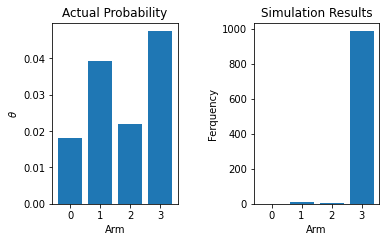

In [32]:
arm_count = [row[1] for row in sorted(Counter(selected_arms_logisticTS[0,:]).items())]
plt.subplot(1,2,1)
plt.bar(range(4), [Env.p(arm) for arm in arms], tick_label=range(4))
plt.xlabel('Arm')
plt.ylabel(r'$\theta$')
plt.title('Actual Probability')
plt.subplot(1,2,2)
plt.bar(range(4), arm_count, tick_label=range(4))
plt.xlabel('Arm')
plt.ylabel('Ferquency')
plt.title('Simulation Results')
plt.tight_layout(pad=3)
plt.savefig(path_fig + "result_logistic_TS.png")
plt.show()

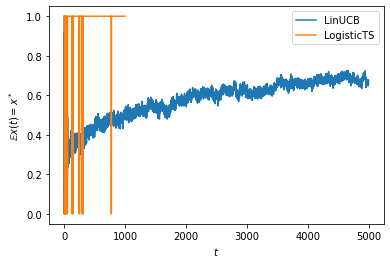

In [33]:
plt.plot(np.mean(selected_arms_linucb==Env.opt(), axis=0), label='LinUCB')
plt.plot(np.mean(selected_arms_logisticTS==Env.opt(), axis=0), label='LogisticTS')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}{x(t) = x^*}$')
plt.legend()
plt.savefig(path_fig  + "compare_logisticTS_vs_linucb.png", bbox_inches="tight")
plt.show()